# Generate correct probabilities and use decision theory

In [1]:
# Import
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import norm
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
from sklearn.metrics import auc,roc_auc_score,recall_score,precision_score,f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
from utils.probs import *

In [4]:
path = Path('../dataset/')

In [5]:
CHEMBL205 = path/'13321_2017_226_MOESM1_ESM/CHEMBL205'

In [6]:
DATA = path/'probabilities'

In [313]:
df_RF = pd.read_csv(DATA/'RF_probabilityfunction_full.csv')

In [314]:
df_RF.head()

,w,p,mu,sigma
0,1.112537e-308,0.794481,3.336147,18.644452
1,1.112537e-308,0.605451,2.962349,18.034830
2,1.544201e-305,0.324171,3.392102,7.701385
3,2.014197e-301,0.664059,2.348809,5.144820
4,2.147754e-292,0.161271,0.688278,6.812526


In [326]:
df_RF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262141 entries, 0 to 262140
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   w       262141 non-null  float64
 1   p       262141 non-null  float64
 2   mu      262141 non-null  float64
 3   sigma   262141 non-null  float64
dtypes: float64(4)
memory usage: 8.0 MB


In [315]:
df_test1 = pd.read_csv(DATA/'modCHEMBL205_predictions_RF.csv')

In [316]:
df_test1.head()

,class,prediction,predicted_class,prediction_int,prediction_lnodds
0,0,0.975,0,195,3.644701
1,0,0.990,0,198,4.547894
2,0,0.950,0,190,2.935226
3,0,0.995,0,199,5.200532
4,1,0.105,1,21,-2.138765


In [317]:
df_output = df_test1.prediction
df_output.head()

0    0.975
1    0.990
2    0.950
3    0.995
4    0.105
Name: prediction, dtype: float64

In [318]:
preds = df_output.to_numpy()

In [319]:
preds

array([0.975, 0.99 , 0.95 , ..., 0.915, 0.99 , 0.3  ])

In [320]:
def RF_direct_prob(x, cl, w, p, m, s):
    """
    Gives probability of class conditional on RF-output
    x = RF output (between 0 and 1)
    cl = class (0 or 1)
    w = array of weights
    p = array of probs
    m = array of means for gaussian
    s = array of standard devs for gaussian
    """
    cl = cl
    c = 1 - 2**-10
    x2 = 0.5 + (x-0.5) * c
    y = np.log(x2/(1-x2))
    pc = p*cl + (1-p) * (1-cl)
    pjoint = np.sum(pc * w * norm.pdf(y, loc=m, scale=s))
    px = np.sum(w * norm.pdf(y, loc=m, scale=s))
    out = pjoint / px
    return out

In [321]:
df = df_RF
mu = df.mu.to_numpy()
sigma = df.sigma.to_numpy()
p = df.p.to_numpy()
w = df.w.to_numpy()

In [322]:
preds

array([0.975, 0.99 , 0.95 , ..., 0.915, 0.99 , 0.3  ])

In [323]:
def get_probs(preds, cl):
    all_probs = np.array([])
    for pred in preds:
        prob = RF_direct_prob(pred, cl, w, p, mu, sigma)
        all_probs = np.append(all_probs, prob)
    return all_probs

In [324]:
all_probs_0 = get_probs(preds, 0)
all_probs_0

array([0.99767754, 0.99805904, 0.99571107, ..., 0.98845363, 0.99805904,
       0.12030366])

In [18]:
all_probs_1 = np.array([])
for pred in preds:
    prob = RF_direct_prob(pred, 1, w, p, mu, sigma)
    all_probs_1 = np.append(all_probs_1, prob)
all_probs_1

array([0.00215156, 0.00167142, 0.00406724, ..., 0.01116059, 0.00167142,
       0.88031513])

In [341]:
df_all = pd.DataFrame()
df_all['class'] = df_test1['class'] 
df_all['pred_0'] = preds
df_all['prob_0'] = all_probs_0
#df_all['probs_class_1'] = all_probs_1
df_all

,class,pred_0,prob_0
0,0,0.975,0.997678
1,0,0.990,0.998059
2,0,0.950,0.995711
3,0,0.995,0.997517
4,1,0.105,0.093190
...,...,...,...
3583,1,0.150,0.097026
3584,0,0.995,0.997517
3585,0,0.915,0.988454
3586,0,0.990,0.998059


In [20]:
df_all['prediction'] = df_all['probs_class_1'] > 0.5
df_all.prediction = df_all.prediction.to_numpy(dtype=int)
df_all.head()

,class,preds,probs_class_0,probs_class_1,prediction
0,0,0.975,0.997848,0.002152,0
1,0,0.990,0.998329,0.001671,0
2,0,0.950,0.995933,0.004067,0
3,0,0.995,0.998112,0.001888,0
4,1,0.105,0.092222,0.907778,1


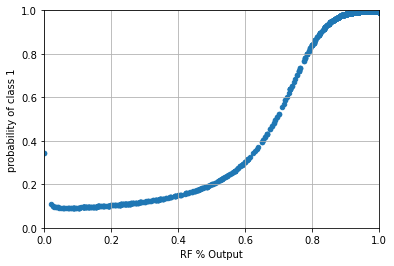

In [330]:
df_all.plot.scatter(x='preds_0', y='probs_0')
plt.xlabel('RF % Output')
plt.ylabel('probability of class 1')
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid()


#plt.savefig('../dataset/RF_output.png')
plt.show()

## Confusion matrix for original predictions

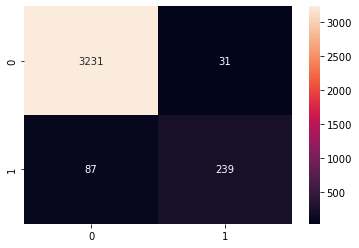

In [331]:
y = df_all['class'].to_numpy()
y_pred = df_test1.predicted_class.to_numpy()
cm = confusion_matrix(y, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')
plt.show()

## Confusion matrix for corrected predictions

In [332]:
y = df_all['class'].to_numpy()
y_pred = df_all.prediction.to_numpy()
cm = confusion_matrix(y, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'prediction'

In [333]:
df_all.to_csv(DATA/'RF_bayesian_prob_test1.csv', index=False)

### same for test set 2

In [404]:
df_test2 = pd.read_csv(f'{CHEMBL205}/CHEMBL205_predictions_RF_test2.csv')
df_test2.head()

,class,predictions,predicted_class
0,0,[0.975 0.025],0
1,0,[0.99 0.01],0
2,0,[0.95 0.05],0
3,0,[0.995 0.005],0
4,1,[0.105 0.895],1


In [405]:
df_test2['preds'] = [get_substring_list(r['predictions'].split(' '))  for i, r in df_test2.iterrows()] # str to list
df_test2['pred_0'] = [r['preds'][0] for i, r in df_test2.iterrows()]
df_test2.head()

,class,predictions,predicted_class,preds,pred_0
0,0,[0.975 0.025],0,"[0.975, 0.025]",0.975
1,0,[0.99 0.01],0,"[0.99, 0.01]",0.990
2,0,[0.95 0.05],0,"[0.95, 0.05]",0.950
3,0,[0.995 0.005],0,"[0.995, 0.005]",0.995
4,1,[0.105 0.895],1,"[0.105, 0.895]",0.105


In [406]:
df_test2 = df_test2.drop(columns=['predictions', 'preds'])
df_test2.head()

,class,predicted_class,pred_0
0,0,0,0.975
1,0,0,0.990
2,0,0,0.950
3,0,0,0.995
4,1,1,0.105


In [407]:
preds = df_test2.pred_0

In [408]:
probs_0 = get_probs(preds, 0)
probs_0

array([0.99767754, 0.99805904, 0.99571107, ..., 0.99805904, 0.12030366,
       0.99767754])

In [409]:
df_test2['prob_0'] = probs_0
df_test2.head()

,class,predicted_class,pred_0,prob_0
0,0,0,0.975,0.997678
1,0,0,0.990,0.998059
2,0,0,0.950,0.995711
3,0,0,0.995,0.997517
4,1,1,0.105,0.093190


In [410]:
df_test2.to_csv(DATA/'RF_bayesian_prob_test2.csv', index=False) # save bayesian probabilites as csv

In [414]:
arr = df_test2[df_test2['pred_0'] == 0.5]
arr = arr[arr['predicted_class'] == 0]
arr

,class,predicted_class,pred_0,prob_0
1479,1,0,0.5,0.199707
1658,1,0,0.5,0.199707
2165,1,0,0.5,0.199707


In [21]:
def choose_class(x, um):
    """
    x = either one number between 0-1, or a (normalized) vector of probabilities
        if it's one number then we are in a binary classification case
        and x is the probability of CLASS 0
    um = utility matrix in the format [[T0,F0],[F1,T1]]
    """
    if type(x) == float or type(x) == np.float64: # x is float and is the probability of class 0
        x = np.array([x])
        x = np.concatenate((x, 1-x)) # transform into prob. vector
    um = np.array(um)
    utilities = np.matmul(um, x)
    cl = np.argmax(utilities)
    return cl

In [64]:
um = np.array([[1, -1], [0, 1]])

In [131]:
c = choose_class(0.6, um)
c

1

In [112]:
cl = np.argmax(utilities)
cl

0

## Test score for regular probability and bayesian probability from utility matrix

In [150]:
df_test2.head() # actual class, prediction from RF, bayesian corrected probability 

,class,pred_0,prob_0
0,0,0.975,0.997848
1,0,0.990,0.998329
2,0,0.950,0.995933
3,0,0.995,0.998112
4,1,0.105,0.092222


### We need to calculate each class chosen with the same utility matrix and then compare

In [289]:
from IPython.display import IFrame
IFrame(DATA/'comparison_schema.pdf', width=1000, height=600)

In [40]:
''' 
Utility matrix format: 
    [[TN, FN],
     [FP, TP]]
'''
um = np.array([[1, -1], [0, 1]])

In [61]:
xs = df_test2['pred_0'].to_numpy()
xs

array([0.975, 0.99 , 0.95 , ..., 0.99 , 0.3  , 0.975])

In [76]:
df_test2['class_pred_0'] = np.array(df_test2['pred_0'] < 0.5, dtype=int)
df_test2.head()

,class,pred_0,prob_0,ut_class_prob_0,class_pred_0
0,0,0.975,0.997848,0,0
1,0,0.990,0.998329,0,0
2,0,0.950,0.995933,0,0
3,0,0.995,0.998112,0,0
4,1,0.105,0.092222,1,1


In [43]:
df_test2['ut_class_prob_0'] = [choose_class(r['prob_0'], um) for i, r  in df_test2.iterrows()]
df_test2.head()

,class,pred_0,prob_0,ut_class_pred_0,ut_class_prob_0
0,0,0.975,0.997848,0,0
1,0,0.990,0.998329,0,0
2,0,0.950,0.995933,0,0
3,0,0.995,0.998112,0,0
4,1,0.105,0.092222,1,1


### Check confusion matrix for the 2 outputs from the utility matrix

In [109]:
def get_total_cost (um, cm):
    if um.max() > 1: # highest number in utility matrix == 1
        um /= np.abs(um).max()
    s = um * cm
    s = s.sum()
    return s

In [100]:
''' 
Utility matrix format: 
    [[TN, FN],
     [FP, TP]]
'''
um = np.array([[1, 0], [-1, 1]])

Confusion matrix for RF output:


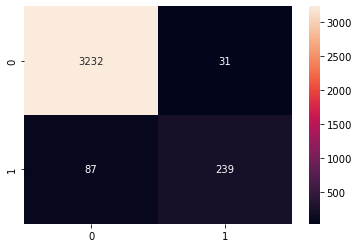

In [107]:
# Confusion matrix for RF output
y = df_test2['class'].to_numpy()
y_pred = df_test2['class_pred_0'].to_numpy()
cm = confusion_matrix(y, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')
print('Confusion matrix for RF output:')
plt.show()

In [108]:
cost = get_total_cost(um, cm)
print(f'Total gains/loss for confusion matrix above: {cost}')

Total gains/loss for confusion matrix above: 3384


Confusion matrix for bayesian probability output combined with utility matrix:


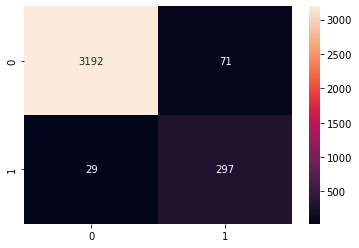

In [109]:
# Confusion matrix for bayesian probability output combined with utility matrix
y = df_test2['class'].to_numpy()
y_pred = df_test2['ut_class_prob_0'].to_numpy()
cm = confusion_matrix(y, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')
print('Confusion matrix for bayesian probability output combined with utility matrix:')
plt.show()

In [110]:
cost = get_total_cost(um, cm)
print(f'Total gains/loss for confusion matrix above: {cost}')

Total gains/loss for confusion matrix above: 3460


# Decision theory

### Test an example with gains/losses

In [54]:
''' 
Utility matrix format: 
    [[TN, FN],
     [FP, TP]]
'''
M = np.array([[15,-80],
              [-1,0]], dtype=float)
#M /= np.abs(M).max()
M = torch.from_numpy(M)
M = M.to(torch.float64)
M

tensor([[ 15., -80.],
        [ -1.,   0.]], dtype=torch.float64)

In [55]:
test1 = np.array([[0.18, 0.02], [0.32, 0.48]], dtype=np.float64)
test2 = np.array([[0.16, 0.04], [0.08, 0.72]], dtype=np.float64)

In [56]:
res1 = M * test1
res2 = M * test2

In [57]:
sum1, sum2 = res1.sum(), res2.sum()
print('Gains from algorithms:')
print(f'#1 {sum1:.2f}, #2 {sum2:.2f}')

Gains from algorithms:
#1 0.78, #2 -0.88


### Create a function for a utility matrix with cost for each case (TN, FP, FN, TP)

In [154]:
utility = np.array([[10, -1], [-10, 1]], dtype=np.float64)

In [139]:
def get_expected_cost (um, m):
    if um.max() > 1:
        if m.max() > 1:
            um /= np.abs(um).max()
    s = um * m
    s1 = s[0].sum()
    s2 = s[1].sum()
    return [s1, s2]

In [7]:
def get_expected_cost (um, m):
    m = np.array(m)
    if um.max() > 1:
        if m.max() > 1:
            um /= np.abs(um).max()
    s1 = um[0] * m
    s2 = um[1] * m
    s1 = s1.sum()
    s2 = s2.sum()
    return [s1, s2]

In [122]:
cm = confusion_matrix(y, y_pred)
cm

array([[3231,   31],
       [  87,  239]])

In [146]:
cost = get_cost(utility, cm[1])
cost

326.0

In [141]:
c = get_expected_cost(utility, cm)
c

[3231.0, 239.0]

In [163]:
df_all['probs'] = [[r['probs_class_0'], r['probs_class_1']] for i, r in df_all.iterrows()]
df_all.head()

,class,preds,probs_class_0,probs_class_1,prediction,probs
0,0,0.975,0.997848,0.002152,0,"[0.9978484371013459, 0.002151562898654075]"
1,0,0.990,0.998329,0.001671,0,"[0.998328584124416, 0.0016714158755837688]"
2,0,0.950,0.995933,0.004067,0,"[0.9959327602479192, 0.004067239752081032]"
3,0,0.995,0.998112,0.001888,0,"[0.9981116284172469, 0.0018883715827530312]"
4,1,0.105,0.092222,0.907778,1,"[0.09222187670619506, 0.9077781232938047]"


In [169]:
''' 
Utility matrix format: 
    [[TN, FN],
     [FP, TP]]
'''
utility = np.array([[1, -1], 
                    [-1, 1]], dtype=np.float64)

In [134]:
def get_expected_utility (um, m):
    '''
    um = utility matrix in format     [[TN, FN], [FP, TP]]
    m = prediction or probability of class [0, 1]
    returns expected utility for each class
    '''
    m = np.array(m)
    if um.max() > 1:
        if m.max() > 1:
            um /= np.abs(um).max()
    s1 = um[0] * m
    s2 = um[1] * m
    s1 = s1.sum()
    s2 = s2.sum()
    return [s1, s2]

In [171]:
df_all['expected_utility'] = [get_expected_utility(utility, r['probs']) for i, r in df_all.iterrows()]
df_all['best_utility_class'] = torch.tensor(df_all['expected_utility']).argmax(axis=1)
df_utility = df_all.drop(columns= ['prediction', 'preds'])
df_utility.head()

,class,probs_class_0,probs_class_1,probs,expected_utility,best_utility_class
0,0,0.997848,0.002152,"[0.9978484371013459, 0.002151562898654075]","[0.9956968742026918, -0.9956968742026918]",0
1,0,0.998329,0.001671,"[0.998328584124416, 0.0016714158755837688]","[0.9966571682488323, -0.9966571682488323]",0
2,0,0.995933,0.004067,"[0.9959327602479192, 0.004067239752081032]","[0.9918655204958382, -0.9918655204958382]",0
3,0,0.998112,0.001888,"[0.9981116284172469, 0.0018883715827530312]","[0.9962232568344939, -0.9962232568344939]",0
4,1,0.092222,0.907778,"[0.09222187670619506, 0.9077781232938047]","[-0.8155562465876096, 0.8155562465876096]",1


In [ ]:
df_utility.to_csv(DATA/'RF_direct_prob_utility.csv', index=False)

# Generate correct probabilities for CNN model for test1 and test2

In [27]:
df_CNN = pd.read_csv(DATA/'CNN_probabilityfunction_full.csv')
df_CNN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262142 entries, 0 to 262141
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   w       262142 non-null  float64
 1   p       262142 non-null  float64
 2   mu0     262142 non-null  float64
 3   sigma0  262142 non-null  float64
 4   mu1     262142 non-null  float64
 5   sigma1  262142 non-null  float64
dtypes: float64(6)
memory usage: 12.0 MB


In [28]:
df_CNN.head()

,w,p,mu0,sigma0,mu1,sigma1
0,1.112547e-308,0.174027,2.249256,5.060917,-2.448301,0.254581
1,2.021356e-302,0.465301,1.497763,0.403940,-4.069391,0.219020
2,2.451473e-297,0.478021,2.776968,2.754942,-1.012342,0.758008
3,1.542531e-295,0.992075,3.959678,0.091651,-0.177518,0.689752
4,2.402227e-289,0.332206,2.568715,0.593366,-0.892260,0.143567


In [29]:
#function for making a list of strings in df to list of floats
def get_substring_list(split):
    if len(split) <= 1:
        print('nooo')
    i = 0
    while len(split[i]) <= 1:
        i += 1
    s1 = split[i]
    i += 1
    while len(split[i]) <= 1:
        i += 1
    s2 = split[i]
    if s1[0] == '[':
        s1 = s1[1:]
    if s2[-1] == ']':
        s2 = s2[0:-1]
    s1 = np.float64(s1)
    s2 = np.float64(s2)
    return [s1, s2]

### Test1

In [141]:
df_test1 = pd.read_csv(CHEMBL205/'CHEMBL205_predictions_CNN_test1.csv')
df_test1['preds'] = [get_substring_list(r['predictions'].split(' '))  for i, r in df_test1.iterrows()]
#df_preds['pred_0'] = np.array(df_preds['pred_0'], dtype=np.float64)
df_test1.head()

,class,predictions,predicted_class,preds
0,0,[1.0686324 0.15983486],1.068632,"[1.0686324, 0.15983486]"
1,0,[ 3.294977 -3.2591858],3.294977,"[3.294977, -3.2591858]"
2,0,[ 3.8328545 -3.5713747],3.832854,"[3.8328545, -3.5713747]"
3,0,[ 3.13148 -3.6825964],3.131480,"[3.13148, -3.6825964]"
4,1,[-0.78947127 1.3680041 ],1.368004,"[-0.78947127, 1.3680041]"


In [24]:
def calculate_probs_CNN(df, df_preds):
    '''
    function for getting bayesian corrected probabilites for CNN
    df = DataFrame for CNN parameters for the probability function
    df_preds = DataFrame for the predictions
    '''
    
    preds = df_preds['preds']
    m0 = df.mu0.to_numpy()
    s0 = df.sigma0.to_numpy()
    m1 = df.mu1.to_numpy()
    s1 = df.sigma1.to_numpy()
    p = df.p.to_numpy()
    w = df.w.to_numpy()
    all_probs_0 = np.array([])
    for pred in preds:
        prob = CNN_direct_prob(pred, 0, w, p, m0, s0, m1, s1)
        all_probs_0 = np.append(all_probs_0, prob)
    return all_probs_0

In [148]:
arr = calculate_probs_CNN(df_CNN, df_test1)
arr

KeyboardInterrupt: 

In [17]:
len(arr)

3589

In [18]:
type(arr)

numpy.ndarray

In [20]:
df_test1['predictions'] = df_test1['preds']
df_test1['direct_prob_0'] = arr
df_test1 = df_test1.drop(columns=['preds', 'predicted_class'])

In [21]:
df_test1.head()

,class,predictions,direct_prob_0
0,0,"[1.0686324, 0.15983486]",0.812226
1,0,"[3.294977, -3.2591858]",0.997830
2,0,"[3.8328545, -3.5713747]",0.995896
3,0,"[3.13148, -3.6825964]",0.997027
4,1,"[-0.78947127, 1.3680041]",0.230960


In [32]:
df_test1.to_csv(DATA/'CNN_bayesian_prob_test1.csv', index=False)

### Do the same for test set 2

In [75]:
df_test2 = pd.read_csv(CHEMBL205/'CHEMBL205_predictions_CNN_test2.csv')
df_test2['preds'] = [get_substring_list(r['predictions'].split(' '))  for i, r in df_test2.iterrows()]
#df_preds['pred_0'] = np.array(df_preds['pred_0'], dtype=np.float64)
df_test2.head()

,class,predictions,predicted_class,preds
0,0,[1.0686324 0.15983486],1.068632,"[1.0686324, 0.15983486]"
1,0,[ 3.294977 -3.2591858],3.294977,"[3.294977, -3.2591858]"
2,0,[ 3.8328545 -3.5713747],3.832854,"[3.8328545, -3.5713747]"
3,0,[ 3.13148 -3.6825964],3.131480,"[3.13148, -3.6825964]"
4,1,[-0.78947127 1.3680041 ],1.368004,"[-0.78947127, 1.3680041]"


In [76]:
probs = calculate_probs_CNN(df_CNN, df_test2)

In [77]:
df_test2['predictions'] = df_test2['preds']
df_test2['prob_0'] = probs
df_test2 = df_test2.drop(columns=['preds', 'predicted_class'])

In [78]:
df_test2.head()

,class,predictions,prob_0
0,0,"[1.0686324, 0.15983486]",0.812226
1,0,"[3.294977, -3.2591858]",0.997830
2,0,"[3.8328545, -3.5713747]",0.995896
3,0,"[3.13148, -3.6825964]",0.997027
4,1,"[-0.78947127, 1.3680041]",0.230960


In [79]:
df_test2['pred_0'] = [r['predictions'][0] for i, r in df_test2.iterrows()]
df_test2['pred_1'] = [r['predictions'][1] for i, r in df_test2.iterrows()]
df_test2 = df_test2.drop(columns=['predictions'])

In [80]:
df_test2.head()

,class,prob_0,pred_0,pred_1
0,0,0.812226,1.068632,0.159835
1,0,0.997830,3.294977,-3.259186
2,0,0.995896,3.832854,-3.571375
3,0,0.997027,3.131480,-3.682596
4,1,0.230960,-0.789471,1.368004


In [81]:
df_test2 = df_test2[['class', 'pred_0', 'pred_1', 'prob_0']]
df_test2.head()

,class,pred_0,pred_1,prob_0
0,0,1.068632,0.159835,0.812226
1,0,3.294977,-3.259186,0.997830
2,0,3.832854,-3.571375,0.995896
3,0,3.131480,-3.682596,0.997027
4,1,-0.789471,1.368004,0.230960


In [82]:
df_test2.to_csv(DATA/'CNN_bayesian_prob_test2.csv', index=False)

## Test for utility matrix

In [136]:
''' 
Utility matrix format: 
    [[TN, FN],
     [FP, TP]]
'''
utility = np.array([[1, 0], 
                    [0, 1]], dtype=np.float64)

In [138]:
df = df_preds
df['expected_utility'] = [get_expected_utility(utility, [r['direct_prob_0'], 1 - r['direct_prob_0']]) 
                          for i, r in df.iterrows()]
df['best_utility_class'] = torch.tensor(df['expected_utility']).argmax(axis=1)

In [139]:
df.head()

,class,predictions,predicted_class,direct_prob_0,expected_utility,best_utility_class
0,0,"[1.0686345, 0.15982893]",0,0.812227,"[0.8122267607382875, 0.18777323926171252]",0
1,0,"[3.294972, -3.2591784]",0,0.997830,"[0.997829581810393, 0.0021704181896069485]",0
2,0,"[3.8328488, -3.5713756]",0,0.995896,"[0.9958956353188672, 0.004104364681132844]",0
3,0,"[3.1314778, -3.682592]",0,0.997027,"[0.9970271557275053, 0.002972844272494668]",0
4,1,"[-0.789468, 1.3680037]",1,0.230961,"[0.2309608425386519, 0.7690391574613481]",1


,class,direct_prob_0,prediction_0
0,0,0.812227,1.068634
1,0,0.997830,3.294972
2,0,0.995896,3.832849
3,0,0.997027,3.131478
4,1,0.230961,-0.789468


In [189]:
df_save = df_preds
df_save.to_csv(DATA/'CNN_direct_prob.csv', index=False)

# Create and compare different utility matrix for test set 2 in CNN and RF models

In [342]:
''' 
Utility matrix format: 
    [[TN, FN],
     [FP, TP]]
'''
ums = {
    'um1' : [[1, 0], [0, 1]], # accuracy
    'um2' : [[1, -1], [0, 1]],
    'um3' : [[1, 0], [-1, 1]],
    'um4' : [[10, 0], [0, 1]],
    'um5' : [[1, 0], [0, 10]],
    'um6' : [[1, -10], [0, 1]],
    'um7' : [[1, 0], [-10, 1]],
    'um8' : [[5, 0], [0, 1]],
    'um9' : [[100, 0], [0, 1]],
    'um10' : [[1, 0], [0, 5]],
    'um11' : [[1, 0], [0, 100]],
    'um12' : [[1, 0], [-5, 1]],
    'um13' : [[1, -5], [0, 1]],
    'um14' : [[1, 0], [-100, 1]],
    'um15' : [[1, -100], [0, 1]],
    
}

## Test for random forest model

In [343]:
def choose_class(x, um=None):
    """
    x = either one number between 0-1, or a (normalized) vector of probabilities
        if it's one number then we are in a binary classification case
        and x is the probability of CLASS 0
    um = utility matrix in the format [[T0,F0],[F1,T1]] if None: Choose class based on x
    """
    if type(x) == float or type(x) == np.float64: # x is float and is the probability of class 0
        x = np.array([x])
        x = np.concatenate((x, 1-x)) # transform into prob. vector
    if um != None:
        um = np.array(um)
        utilities = np.matmul(um, x)
        cl = np.argmax(utilities)
    else:
        cl = np.argmax(x)
    return cl

In [345]:
def get_total_cost (um, cm):
    um = np.array([np.array(x) for x in um])
    um = np.array([[um[0][0], um[1][0]], [um[0][1], um[1][1]]]) # switch the ordering of                             
    um = um - um.min()                                          #t he cm to match [[TN, FP], [FN, TP]]
    um = um / um.max() # Matrix to have max = 1 and min = 0
    s = um * cm
    s = s.sum()
    s = s / cm.sum()
    return s

In [346]:
df_test2_RF = pd.read_csv(DATA/'RF_bayesian_prob_test2.csv')
df_test2_RF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3589 entries, 0 to 3588
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   class   3589 non-null   int64  
 1   pred_0  3589 non-null   float64
 2   prob_0  3589 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 84.2 KB


In [347]:
df_test2_RF.head()

,class,pred_0,prob_0
0,0,0.975,0.997678
1,0,0.990,0.998059
2,0,0.950,0.995711
3,0,0.995,0.997517
4,1,0.105,0.093190


In [348]:
#df_test2_RF['predictions'] = [np.array([r['pred_0'], 1. - r['pred_0']]) for i, r in df_test2_RF.iterrows()]
#df_test2_RF['probabilities'] = [np.array([r['prob_0'], 1 - r['prob_0']]) for i, r in df_test2_RF.iterrows()]
df_test2_RF.head()

,class,pred_0,prob_0
0,0,0.975,0.997678
1,0,0.990,0.998059
2,0,0.950,0.995711
3,0,0.995,0.997517
4,1,0.105,0.093190


In [392]:
df_scores = pd.DataFrame()
df_scores['ums'] = list(ums.values())

In [393]:
df_scores

,ums
0,"[[1, 0], [0, 1]]"
1,"[[1, -1], [0, 1]]"
2,"[[1, 0], [-1, 1]]"
3,"[[10, 0], [0, 1]]"
4,"[[1, 0], [0, 10]]"
5,"[[1, -10], [0, 1]]"
6,"[[1, 0], [-10, 1]]"
7,"[[5, 0], [0, 1]]"
8,"[[100, 0], [0, 1]]"
9,"[[1, 0], [0, 5]]"


In [387]:
def get_utility_scores(df, um, verbose=True):
    '''
    Method for calculating the total gains from utility matrix for regular predictions 
    and bayesian corrected predictions
    df = DataFrame for predictions and bayesian probabilites of class 0
    um = utility matrix in the format [[T0,F0],[F1,T1]]
    verbose = if True: Outputs confusion matrix and text
    '''
    # Calculations for standard output
    y = df['class'].to_numpy()
    if 'pred_1' in df.columns:
        y_pred = [choose_class([r['pred_0'], r['pred_1']]) for i, r in df.iterrows()]
    else:
        y_pred = [choose_class(r['pred_0']) for i, r in df.iterrows()]
    cm1 = confusion_matrix(y, y_pred)
    c1 = get_total_cost(um, cm1)
    if verbose: 
        f = sns.heatmap(cm1, annot=True, fmt='d')
        print('**Output for the standard predictions from algorithm**')
        print(f'Utility Matrix: {um}')
        print(f'Total gains for the Utility Matrix: {c1}')
        print('Confusion matrix:')
        plt.show()
    # Calculations for standard output with expected utility class choice
    if 'pred_1' in df.columns:
        y_pred = [choose_class([r['pred_0'], r['pred_1']], um) for i, r in df.iterrows()]
    else:
        y_pred = [choose_class(r['pred_0'], um) for i, r in df.iterrows()]
    cm2 = confusion_matrix(y, y_pred)
    c2 = get_total_cost(um, cm2)
    if verbose: 
        f = sns.heatmap(cm2, annot=True, fmt='d')
        print('**Output for the standard predictions from algorithm with expected utility**')
        print(f'Utility Matrix: {um}')
        print(f'Total gains for the Utility Matrix: {c2}')
        print('Confusion matrix:')
        plt.show()
    # Calculations for bayesian probability and expected utility class choice
    y_pred = [choose_class(r['prob_0'], um) for i, r in df.iterrows()]
    cm3 = confusion_matrix(y, y_pred)
    c3 = get_total_cost(um, cm3)
    if verbose: 
        f = sns.heatmap(cm3, annot=True, fmt='d')
        print('**Output for the bayesian calculations with expected utility**')
        print(f'Utility Matrix: {um}')
        print(f'Total gains: {c3}')
        print('Confusion matrix:')
        plt.show()
    return c1, c2, c3

**Output for the standard predictions from algorithm**
Utility Matrix: [[1, 0], [-10, 10]]
Total gains for the Utility Matrix: 0.5740039008080247
Confusion matrix:


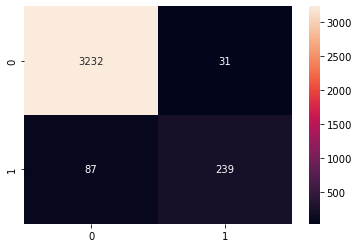

**Output for the standard predictions from algorithm with expected utility**
Utility Matrix: [[1, 0], [-10, 10]]
Total gains for the Utility Matrix: 0.5736416829200335
Confusion matrix:


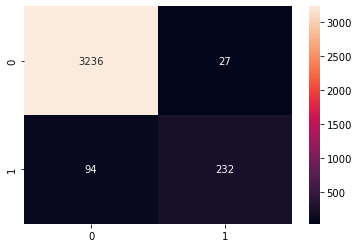

**Output for the bayesian calculations with expected utility**
Utility Matrix: [[1, 0], [-10, 10]]
Total gains: 0.5775703538590137
Confusion matrix:


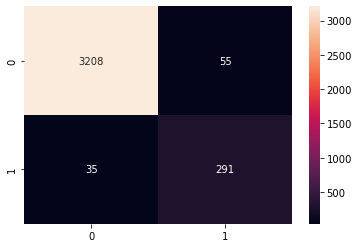

In [388]:
c1, c2, c3 = get_utility_scores(df_test2_RF, [[1, 0], [-10, 10]])

In [358]:
df_scores.iloc[0].to_numpy()

array([list([[1, 0], [0, 1]])], dtype=object)

In [359]:
um = np.array([[1, 0], [0, 1]])

In [360]:
um = um - um.min()
um = um / um.max()
um

array([[1., 0.],
       [0., 1.]])

In [361]:
um[1][1]

1.0

# Get the scores for all the different utility matrixes

In [381]:
scores1 = []
scores2 = []
scores3 = []
for i, r in df_scores.iterrows():
    s1, s2, s3 = get_utility_scores(df_test2_RF, r['ums'], verbose=False)
    scores1.append(s1)
    scores2.append(s2)
    scores3.append(s3)
scores1, scores2, scores3

([0.967121760936194,
  0.9714405126776261,
  0.9792421287266648,
  0.9071886319309,
  0.15664530509891336,
  0.9749740368297068,
  0.9891587932825046,
  0.9138478684870438,
  0.9011953190303705,
  0.24669824463638898,
  0.07559765951518528,
  0.9873223739203121,
  0.9743196805052475,
  0.991122489234156,
  0.9756737445825943],
 [0.967121760936194,
  0.9827249930342714,
  0.9746447478406242,
  0.9097241571468375,
  0.17035385901365285,
  0.9881962562374933,
  0.9920210744953013,
  0.9127890777375314,
  0.9091724714405127,
  0.26057397603789356,
  0.09213987183059348,
  0.9867186774403269,
  0.9889941487879632,
  0.9991061797737311,
  0.9922921799006315],
 [0.9749233769852327,
  0.98202842017275,
  0.9807745890220118,
  0.9091668988576205,
  0.17305656171635553,
  0.991970414650827,
  0.9917424453506928,
  0.9146837559208694,
  0.9091668988576205,
  0.2607411535246587,
  0.09729172471440513,
  0.9887155196433547,
  0.9887155196433547,
  0.999100662364927,
  0.9973792308180387])

In [394]:
df_scores['RF_output'] = scores1
df_scores['RF_utility'] = scores2
df_scores['RF_bayesian_utility'] = scores3
df_scores

,ums,RF_output,RF_utility,RF_bayesian_utility
0,"[[1, 0], [0, 1]]",0.960713,0.960713,0.962385
1,"[[1, -1], [0, 1]]",0.972834,0.973530,0.973112
2,"[[1, 0], [-1, 1]]",0.968236,0.967679,0.972276
3,"[[10, 0], [0, 1]]",0.892505,0.891725,0.909167
4,"[[1, 0], [0, 10]]",0.164280,0.166063,0.168877
5,"[[1, -10], [0, 1]]",0.982750,0.984574,0.987690
6,"[[1, 0], [-10, 1]]",0.974391,0.973378,0.991742
7,"[[5, 0], [0, 1]]",0.900084,0.899359,0.910560
8,"[[100, 0], [0, 1]]",0.885684,0.885352,0.909167
9,"[[1, 0], [0, 5]]",0.252772,0.254277,0.254723


In [364]:
df_test2_CNN = pd.read_csv(DATA/'CNN_bayesian_prob_test2.csv')

In [389]:
scores1 = []
scores2 = []
scores3 = []
for i, r in df_scores.iterrows():
    s1, s2, s3 = get_utility_scores(df_test2_CNN, r['ums'], verbose=False)
    scores1.append(s1)
    scores2.append(s2)
    scores3.append(s3)
scores1, scores2, scores3

([0.9607132906101978,
  0.9728336584006687,
  0.968236277514628,
  0.8925048760100306,
  0.16427974366118697,
  0.9827503229565085,
  0.9743914486182527,
  0.9000835887433826,
  0.8856840345500139,
  0.25277235998885483,
  0.08463638896628588,
  0.9732516021175815,
  0.980913903594316,
  0.9756102943813468,
  0.98471401890816],
 [0.9607132906101978,
  0.9735302312621901,
  0.967679019225411,
  0.8917247144051268,
  0.16606297018668154,
  0.9845740773575825,
  0.9733782517287672,
  0.8993591529674004,
  0.8853524658679298,
  0.2542769573697409,
  0.08765115631095012,
  0.9723692764929879,
  0.9825392402711991,
  0.975279249853099,
  0.9877292828196166],
 [0.962385065477849,
  0.9731122875452772,
  0.9722764001114517,
  0.9091668988576205,
  0.16887712454722764,
  0.9876896577927506,
  0.9917424453506928,
  0.9105600445806631,
  0.9091668988576205,
  0.25472276400111454,
  0.09559208693229311,
  0.9857899136249652,
  0.9842110151388502,
  0.999100662364927,
  0.9956605579755523])

In [395]:
df_scores['CNN_output'] = scores1
df_scores['CNN_utility'] = scores2
df_scores['CNN_bayesian_utility'] = scores3
df_scores

,ums,RF_output,RF_utility,RF_bayesian_utility,CNN_output,CNN_utility,CNN_bayesian_utility
0,"[[1, 0], [0, 1]]",0.960713,0.960713,0.962385,0.960713,0.960713,0.962385
1,"[[1, -1], [0, 1]]",0.972834,0.973530,0.973112,0.972834,0.973530,0.973112
2,"[[1, 0], [-1, 1]]",0.968236,0.967679,0.972276,0.968236,0.967679,0.972276
3,"[[10, 0], [0, 1]]",0.892505,0.891725,0.909167,0.892505,0.891725,0.909167
4,"[[1, 0], [0, 10]]",0.164280,0.166063,0.168877,0.164280,0.166063,0.168877
5,"[[1, -10], [0, 1]]",0.982750,0.984574,0.987690,0.982750,0.984574,0.987690
6,"[[1, 0], [-10, 1]]",0.974391,0.973378,0.991742,0.974391,0.973378,0.991742
7,"[[5, 0], [0, 1]]",0.900084,0.899359,0.910560,0.900084,0.899359,0.910560
8,"[[100, 0], [0, 1]]",0.885684,0.885352,0.909167,0.885684,0.885352,0.909167
9,"[[1, 0], [0, 5]]",0.252772,0.254277,0.254723,0.252772,0.254277,0.254723


In [396]:
df_scores.to_csv(DATA/'scores_utility_matrix.csv', index=False)